# What happens if I want to model the particle background?

The "standard" analysis routine for PHA data is some variant of

- load in data
- select the region of interest
- setup the model, statistic, and optimiser
- fit
- error analysis
- repeat the above tweaking various steps
- profit (which is different from Randall Smith's [profit](https://heasarc.gsfc.nasa.gov/docs/software/profit/) package)

There are many ways to complicate this, and one of them is to try and deal with features for which the standard response (i.e. ARF and RMF) are not valid, such as instrumental or the particle background (which tends not to see the lovely ARF you've lovingly crafted for your analysis).

For Sherpa we can use the [set_full_model](https://cxc.cfa.harvard.edu/sherpa/ahelp/set_full_model.html) and [set_bkg_full_model](https://cxc.cfa.harvard.edu/sherpa/ahelp/set_bkg_full_model.html) commands to set up a model where we declare the respones to use, rather than having them automatically added by Sherpa as you do with [set_source](https://cxc.cfa.harvard.edu/sherpa/ahelp/set_source.html) and [set_bkg_source](https://cxc.cfa.harvard.edu/sherpa/ahelp/set_bkg_source.html).

First let's look at how we fit the background rather than just subtracting it.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sherpa.astro.ui import *

set_stat('chi2datavar')

In part because I can, but it will be useful below, I decide to use a data set with a non-default id - in this case `"simple"` - which will mean this is often the first argument to a command:

In [2]:
load_pha('simple', 'data/acisf04938_000N002_r0043_pha3.fits')
notice_id('simple', 0.5, 7)

# I could have said
# notice(0.5, 7)
# as it is applied to all loaded data sets.

read ARF file data/acisf04938_000N002_r0043_arf3.fits
read RMF file data/acisf04938_000N002_r0043_rmf3.fits
read background file data/acisf04938_000N002_r0043_pha3.fits


We don't have a "canned" plot command to show the data and background, so we can use the generic [plot](https://cxc.cfa.harvard.edu/sherpa/ahelp/plot.html) command:

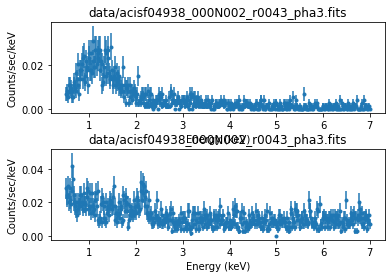

In [3]:
plot('data', 'simple', 'bkg', 'simple')

What happens with commands like `group_counts`? The `if` checks are just to show that groupnig data has been created for both the source and background data sets by the `group_counts` call:

In [4]:
data = get_data('simple')
bkg = get_bkg('simple')

if data.grouping is None and bkg.grouping is None:
    print("NOTE: no grouping")

group_counts('simple', 20, tabStops=~data.get_mask())

if data.grouping is not None and bkg.grouping is not None:
    print("NOTE: we have grouping")

NOTE: no grouping
NOTE: we have grouping


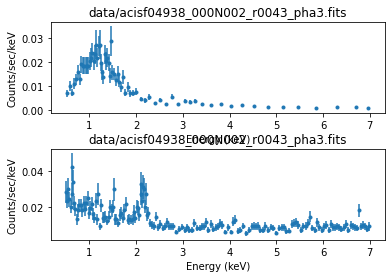

In [5]:
plot('data', 'simple', 'bkg', 'simple')

We can see the same grouping values are used for the two data sets - this is more-easily seen in a Jupyter notebook where we can take advantage of the rich-output interface for the data objects (here `data` and `bkg`) as the "Summary" section lists the number of groups within the filter: 67 for the data and 158 for the background.

In [6]:
data

<DataPHA data set instance 'data/acisf04938_000N002_r0043_pha3.fits'>

In [7]:
bkg

<DataPHA data set instance 'data/acisf04938_000N002_r0043_pha3.fits'>

Let's try to fit a model to the background - it looks fairly flat at high energies and some extra emission at low energies:

In [8]:
set_bkg_model("simple", xsapec.bgas + powlaw1d.bpl1)
bgas.abundanc.thaw()

In [9]:
fit_bkg('simple')

Dataset               = simple
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 1.24603e+12
Final fit statistic   = 631.476 at function evaluation 434
Data points           = 158
Degrees of freedom    = 153
Probability [Q-value] = 2.28967e-59
Reduced statistic     = 4.12729
Change in statistic   = 1.24603e+12
   bgas.kT        0.559916     +/- 0.0528225   
   bgas.Abundanc   0            +/- 0.00480932  
   bgas.norm      0.00068117   +/- 9.35982e-05 
   bpl1.gamma     -0.823298    +/- 0.0925575   
   bpl1.ampl      1.21325e-05  +/- 1.64332e-06 


It turns out this is not the best-looking fit!

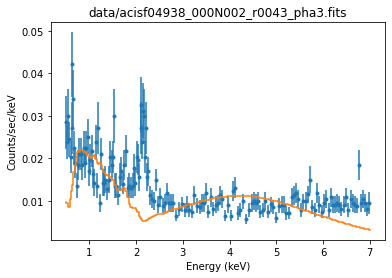

In [10]:
plot_bkg_fit('simple')

Let's add an extra power-law term so we can have one helping out the low-energy data and the other for the higher-energy term:

In [11]:
set_bkg_source('simple', bgas + bpl1 + powlaw1d.bpl2)
bpl2.gamma = 1

fit_bkg('simple')

Dataset               = simple
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 3.83246e+11
Final fit statistic   = 408.608 at function evaluation 544
Data points           = 158
Degrees of freedom    = 151
Probability [Q-value] = 1.33737e-25
Reduced statistic     = 2.70601
Change in statistic   = 3.83246e+11
   bgas.kT        0.0441298    +/- 0           
   bgas.Abundanc   0.209952     +/- 0           
   bgas.norm      1.21455      +/- 0           
   bpl1.gamma     -6.33242     +/- 0           
   bpl1.ampl      6.91234e-10  +/- 3.44019e-11 
   bpl2.gamma     0.637791     +/- 0           
   bpl2.ampl      5.86147e-05  +/- 1.38771e-06 


It's potentially better...

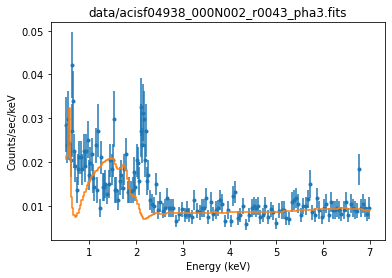

In [12]:
plot_bkg_fit('simple')

We can use [plot_model_component](https://cxc.cfa.harvard.edu/sherpa/ahelp/plot_model_component.html) to see how the various components map to the data.

In this case I am mixing up some commands which are meant to be used for the "source" dataset - `get_response` and `plot_model_component` - and those for the background (`plot_bkg_model`). This works here because we actually only have a response for the suorce region and we are assuming we can use the same response for the background region. We also don't have a `plot_bkg_model_component` command....

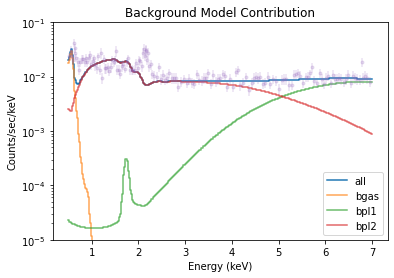

In [13]:
# get_response combines the ARF and RMF (if both loaded, as they are here) to create
# a "model" that converts a model defined on an energy grid to one on channel space.
#
rsp = get_response('simple')

plot_bkg_model('simple', ylog=True)
plot_model_component('simple', rsp(bgas), alpha=0.7, overplot=True)
plot_model_component('simple', rsp(bpl1), alpha=0.7, overplot=True)
plot_model_component('simple', rsp(bpl2), alpha=0.7, overplot=True)

plot_bkg('simple', alpha=0.2, overplot=True)

plt.legend(['all', 'bgas', 'bpl1', 'bpl2'])
plt.ylim(1e-5, 1e-1);

This is all fascinating, but it doesn't really get us any closer to describing this data...

Let's just see what happens if we use this background model (even if we know it is not great):

In [14]:
set_source('simple', xsphabs.gal * powlaw1d.pl)

It turns out that we are not actually at the minimum, as the fit statistic changes quite significally if we re-run it:

In [15]:
fit_bkg('simple')

Dataset               = simple
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 406.978
Final fit statistic   = 282.295 at function evaluation 608
Data points           = 156
Degrees of freedom    = 149
Probability [Q-value] = 2.6922e-10
Reduced statistic     = 1.8946
Change in statistic   = 124.684
   bgas.kT        0.169693     +/- 0           
   bgas.Abundanc   0.0147618    +/- 0           
   bgas.norm      0.00485757   +/- 0           
   bpl1.gamma     -8.01734     +/- 0           
   bpl1.ampl      2.75085e-11  +/- 1.43786e-12 
   bpl2.gamma     0.293178     +/- 0           
   bpl2.ampl      4.38061e-05  +/- 9.96735e-07 


In [16]:
fit_bkg('simple')

Dataset               = simple
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 282.295
Final fit statistic   = 282.295 at function evaluation 279
Data points           = 156
Degrees of freedom    = 149
Probability [Q-value] = 2.6922e-10
Reduced statistic     = 1.8946
Change in statistic   = 0
   bgas.kT        0.169693     +/- 0           
   bgas.Abundanc   0.0147618    +/- 0           
   bgas.norm      0.00485757   +/- 0           
   bpl1.gamma     -8.01734     +/- 0           
   bpl1.ampl      2.75085e-11  +/- 1.43858e-12 
   bpl2.gamma     0.293178     +/- 0           
   bpl2.ampl      4.38061e-05  +/- 9.96752e-07 


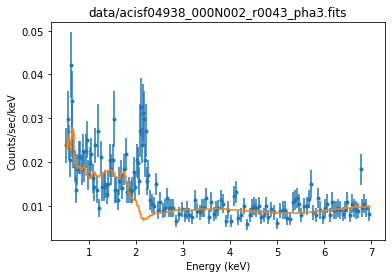

In [17]:
plot_bkg_fit('simple')

Now we've got the background model into a "stable" place we can fit the source (which will include a contribution from the background model):

In [18]:
fit('simple')

Dataset               = simple
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 4.15168e+11
Final fit statistic   = 462.299 at function evaluation 711
Data points           = 223
Degrees of freedom    = 213
Probability [Q-value] = 1.65768e-20
Reduced statistic     = 2.17042
Change in statistic   = 4.15168e+11
   gal.nH         0            +/- 0           
   pl.gamma       1.5167       +/- 0           
   pl.ampl        4.3135e-05   +/- 1.38574e-06 
   bgas.kT        0.167447     +/- 0           
   bgas.Abundanc   0.0137729    +/- 0           
   bgas.norm      0.00531594   +/- 0           
   bpl1.gamma     -8.06715     +/- 0           
   bpl1.ampl      2.52492e-11  +/- 1.28227e-12 
   bpl2.gamma     0.336509     +/- 0           
   bpl2.ampl      4.49494e-05  +/- 1.03217e-06 


In [19]:
fit('simple')

Dataset               = simple
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 462.299
Final fit statistic   = 345.083 at function evaluation 296
Data points           = 223
Degrees of freedom    = 213
Probability [Q-value] = 2.5911e-08
Reduced statistic     = 1.62011
Change in statistic   = 117.217
   gal.nH         0.0408572    +/- 0           
   pl.gamma       2.08791      +/- 0           
   pl.ampl        7.93922e-05  +/- 2.3564e-06  
   bgas.kT        0.168821     +/- 0           
   bgas.Abundanc   0.0148646    +/- 0           
   bgas.norm      0.0049065    +/- 0           
   bpl1.gamma     -7.99623     +/- 0           
   bpl1.ampl      2.90713e-11  +/- 1.46286e-12 
   bpl2.gamma     0.295976     +/- 0           
   bpl2.ampl      4.38744e-05  +/- 9.95978e-07 


In [20]:
fit('simple')

Dataset               = simple
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 345.083
Final fit statistic   = 345.083 at function evaluation 252
Data points           = 223
Degrees of freedom    = 213
Probability [Q-value] = 2.5911e-08
Reduced statistic     = 1.62011
Change in statistic   = 0
   gal.nH         0.0408572    +/- 0           
   pl.gamma       2.08791      +/- 0           
   pl.ampl        7.93922e-05  +/- 2.35596e-06 
   bgas.kT        0.168821     +/- 0           
   bgas.Abundanc   0.0148646    +/- 0           
   bgas.norm      0.0049065    +/- 0           
   bpl1.gamma     -7.99623     +/- 0           
   bpl1.ampl      2.90713e-11  +/- 1.46514e-12 
   bpl2.gamma     0.295976     +/- 0           
   bpl2.ampl      4.38744e-05  +/- 9.96042e-07 


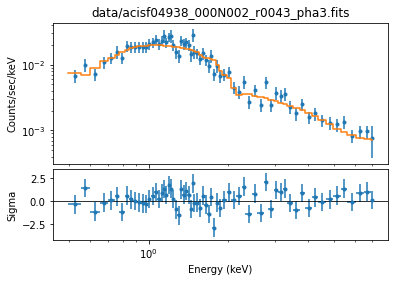

In [21]:
plot_fit_delchi('simple', xlog=True, ylog=True)

# What can we do about the background?

Let's load the background dataset into it's own "label" so we don't have to worry about "bkg" commands. Note that this happens to be a CSC 2.0 source and so the background is stored as the SPECTRUM2 block of the file:

In [22]:
from ciao_contrib import runtool

In [23]:
runtool.dmlist('data/acisf04938_000N002_r0043_pha3.fits', 'blocks')

 
--------------------------------------------------------------------------------
Dataset: data/acisf04938_000N002_r0043_pha3.fits
--------------------------------------------------------------------------------
 
     Block Name                          Type         Dimensions
--------------------------------------------------------------------------------
Block    1: PRIMARY                        Null        
Block    2: SPECTRUM1                      Table         4 cols x 1024     rows
Block    3: GTI3                           Table         2 cols x 1        rows
Block    4: GTI2                           Table         2 cols x 5        rows
Block    5: SPECTRUM2                      Table         4 cols x 1024     rows
Block    6: GTI3_CPT2                      Table         2 cols x 5        rows

In [24]:
runtool.dmkeypar('data/acisf04938_000N002_r0043_pha3.fits[SPECTRUM2]', "ANCRFILE", echo=True)

none

In [25]:
runtool.dmkeypar('data/acisf04938_000N002_r0043_pha3.fits[SPECTRUM2]', "RESPFILE", echo=True)

none

In [26]:
load_pha('bgnd', 'data/acisf04938_000N002_r0043_pha3.fits[SPECTRUM2]')  # This requires CIAO/pycrates as astropy doesn't allow to use this syntax

Note that this does not load in any response information as the `ANCRFILE` and `RESPFILE` headers are set to `none` - we can see this when we plot the data as it uses channel units:

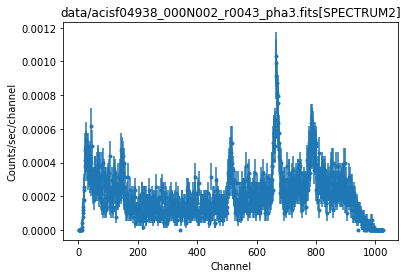

In [27]:
plot_data('bgnd')

What we can do is load the response we want - we could use [get_arf](https://cxc.cfa.harvard.edu/sherpa/ahelp/get_arf.html) and [get_rmf](https://cxc.cfa.harvard.edu/sherpa/ahelp/get_rmf.html) to copy over the data from the `"simple"` dataset, but let's use [load_rmf](https://cxc.cfa.harvard.edu/sherpa/ahelp/load_rmf.html), as I'm going to ignore the ARF (that is treat the model as representing the charged-particle background that just sails through the telescope and ignores the mirror): 

In [28]:
load_rmf('bgnd', 'data/acisf04938_000N002_r0043_rmf3.fits')

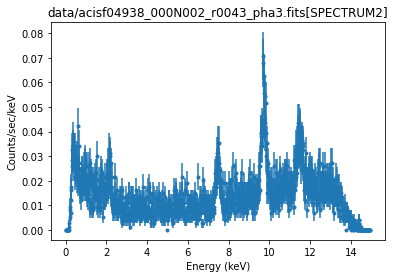

In [29]:
plot_data('bgnd')

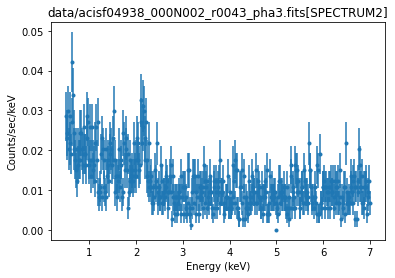

In [30]:
ignore_id('bgnd')
notice_id('bgnd', 0.5, 7)
plot_data('bgnd')

In [31]:
group_counts('bgnd', 20, tabStops=~get_data('bgnd').get_mask())

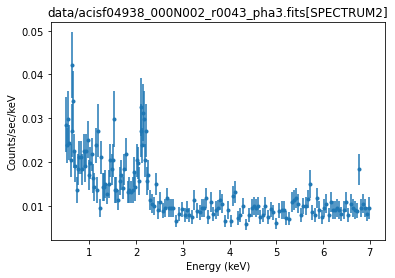

In [32]:
plot_data('bgnd')

**WARNING**

The following model expression has been chosen as it is "slightly complex" (i.e. multiple components) and can be used to reasonably describe this particular background dataset. This is a purely **phenomenological** model and **should not** be used for actual analysis of Chandra data!

There are a bunch of papers that describe modelling the Sherpa background: I suggest "[High-redshift X-ray Cooling-core Cluster Associated with the Luminous Radio-loud Quasar 3C 186](https://ui.adsabs.harvard.edu/abs/2010ApJ...722..102S/abstract)" by Siemiginowska et al but as I'm the second author I may be a bit biased.

In [33]:
set_source('bgnd', powlaw1d.bpl1_bgnd + powlaw1d.bpl2_bgnd + xsgaussian.bline1_bgnd)

# fitting lines in data like this can be tricky, so we set the position to
# be close to where we expect it and treat it as being close to a delta
# function.
#
bline1_bgnd.linee = 2
set_par(bline1_bgnd.sigma, 0.01, frozen=True)

In [34]:
fit('bgnd')

Dataset               = bgnd
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 4.325e+07
Final fit statistic   = 162.075 at function evaluation 417
Data points           = 158
Degrees of freedom    = 152
Probability [Q-value] = 0.273057
Reduced statistic     = 1.06628
Change in statistic   = 4.32499e+07
   bpl1_bgnd.gamma   -3.56345     +/- 1.49661     
   bpl1_bgnd.ampl   4.24041e-06  +/- 1.22218e-05 
   bpl2_bgnd.gamma   0.58096      +/- 0.0507096   
   bpl2_bgnd.ampl   0.0178635    +/- 0.000496128 
   bline1_bgnd.LineE   2.14233      +/- 0.00800686  
   bline1_bgnd.norm   0.00238685   +/- 0.000318647 


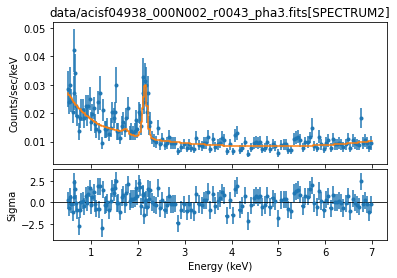

In [35]:
plot_fit_delchi('bgnd')

The model we are fitting is two power-laws and a gaussian:

In [36]:
get_source('bgnd')

<BinaryOpModel model instance '((powlaw1d.bpl1_bgnd + powlaw1d.bpl2_bgnd) + xsgaussian.bline1_bgnd)'>

The actual model being fitted includes the RMF. What this means is that we are effectively treating the ARF as if it has a value of 1.0 for each bin. This means that we are describing emission that "ignores" the mirrors (so not part of the cosmic X-ray background). In reality we should think about including phyiscal models (e.g. the AGN background and emission from the local background), but it depends on whether we want a physically-meaningful model or just a phenomenolgical one. For this notebook we will treat this model as successful.

In [37]:
get_model('bgnd')

<RMFModelPHA model instance 'apply_rmf((50454.152030948 * ((powlaw1d.bpl1_bgnd + powlaw1d.bpl2_bgnd) + xsgaussian.bline1_bgnd)))'>

# How do I use this model?

By loading in the data yet again ...[$\dagger$]

---

$\dagger$ - in reality you wouldn't have quite as many copies of the same data loaded; I am doing it to make things (hopefully) more obvious.

In [38]:
load_pha(99, 'data/acisf04938_000N002_r0043_pha3.fits')

read ARF file data/acisf04938_000N002_r0043_arf3.fits
read RMF file data/acisf04938_000N002_r0043_rmf3.fits
read background file data/acisf04938_000N002_r0043_pha3.fits


In [39]:
notice_id(99, 0.5, 7)
group_counts(99, 20, tabStops=~get_data(99).get_mask())

In [40]:
# I could re-use the components from the bgnd model, but there's a reason why I'm not.
#
set_bkg_source(99, powlaw1d.bpl1_99 + powlaw1d.bpl2_99 + xsgaussian.bline1_99)
bline1_99.linee = 2
set_par(bline1_99.sigma, 0.01, frozen=True)

In [41]:
fit_bkg(99)

Dataset               = 99
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 3.90003e+12
Final fit statistic   = 435.852 at function evaluation 205
Data points           = 158
Degrees of freedom    = 152
Probability [Q-value] = 3.28222e-29
Reduced statistic     = 2.86745
Change in statistic   = 3.90003e+12
   bpl1_99.gamma   -0.744892    +/- 0.0858159   
   bpl1_99.ampl   1.3371e-05   +/- 1.66334e-06 
   bpl2_99.gamma   4.06089      +/- 0.178291    
   bpl2_99.ampl   6.47637e-05  +/- 4.10347e-06 
   bline1_99.LineE   2.14654      +/- 0.00537139  
   bline1_99.norm   1.92432e-05  +/- 1.74944e-06 


Hold on, when I `fit('bgnd')` above I got a reduced statistic of ~1.07, not ~2.9!

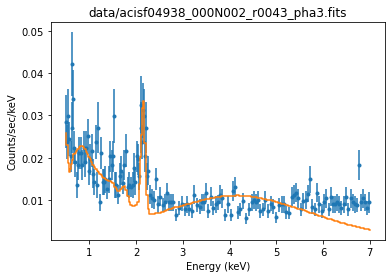

In [42]:
plot_bkg_fit(99)

I we look at the full-model expression (returned by `get_bkg_model`) we can see the reason: this has included the ARF as well as the RMF.

In [43]:
get_bkg_model(99)

<RSPModelPHA model instance 'apply_rmf(apply_arf((50454.152030948 * ((powlaw1d.bpl1_99 + powlaw1d.bpl2_99) + xsgaussian.bline1_99))))'>

How do we get rid of the ARF? Unfortunately we don't have an easy way to do this in CIAO 4.13, so we have to do a trick: read in the ARF and then reset it so that it has values of 1. The current ARF for the background looks like:

In [44]:
get_arf(99, bkg_id=1)

<DataARF data set instance 'data/acisf04938_000N002_r0043_arf3.fits'>

The plan is to read in the ARF, modify the SPECRESP column, and then over-write the existing ARF:

In [45]:
barf = unpack_arf('data/acisf04938_000N002_r0043_arf3.fits')

In [46]:
barf.specresp.shape

(900,)

In [47]:
barf.specresp = np.ones(900)

In [48]:
set_arf(99, barf, bkg_id=1)

Has it worked?

In [49]:
get_arf(99, bkg_id=1)

<DataARF data set instance 'data/acisf04938_000N002_r0043_arf3.fits'>

Let's check the source ARF is un-changed:

In [50]:
get_arf(99)

<DataARF data set instance 'data/acisf04938_000N002_r0043_arf3.fits'>

In [51]:
fit_bkg(99)

Dataset               = 99
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 3824
Final fit statistic   = 162.075 at function evaluation 241
Data points           = 158
Degrees of freedom    = 152
Probability [Q-value] = 0.273057
Reduced statistic     = 1.06628
Change in statistic   = 3661.92
   bpl1_99.gamma   -3.567       +/- 1.49535     
   bpl1_99.ampl   4.21144e-06  +/- 1.23238e-05 
   bpl2_99.gamma   0.580869     +/- 0.0507589   
   bpl2_99.ampl   0.0178635    +/- 0.000496128 
   bline1_99.LineE   2.14233      +/- 0.00800638  
   bline1_99.norm   0.00238674   +/- 0.000318653 


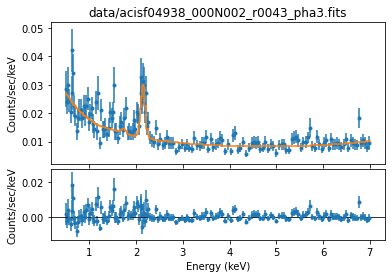

In [52]:
plot_bkg_fit_resid(99)

So, this appears to have worked.

What happens if we fit the source now?

In [53]:
set_source(99, xsphabs.gal_99 * powlaw1d.pl_99)

In [54]:
fit(99)

Dataset               = 99
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 4.17349e+11
Final fit statistic   = 3686.82 at function evaluation 618
Data points           = 225
Degrees of freedom    = 216
Probability [Q-value] = 0
Reduced statistic     = 17.0686
Change in statistic   = 4.17349e+11
   gal_99.nH      4.66815      +/- 0           
   pl_99.gamma    4.176        +/- 0           
   pl_99.ampl     0.000294072  +/- 0           
   bpl1_99.gamma   -9.50809     +/- 0           
   bpl1_99.ampl   3.84951e-12  +/- 1.66549e-13 
   bpl2_99.gamma   1.99901      +/- 0           
   bpl2_99.ampl   0.00117106   +/- 0           
   bline1_99.LineE   0.579914     +/- 0           
   bline1_99.norm   0.000153684  +/- 0           


In [55]:
fit(99)

Dataset               = 99
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 3686.82
Final fit statistic   = 3652.07 at function evaluation 419
Data points           = 225
Degrees of freedom    = 216
Probability [Q-value] = 0
Reduced statistic     = 16.9077
Change in statistic   = 34.7525
   gal_99.nH      9.89613      +/- 0           
   pl_99.gamma    4.28921      +/- 0           
   pl_99.ampl     0            +/- 0           
   bpl1_99.gamma   -9.44684     +/- 0           
   bpl1_99.ampl   3.6949e-12   +/- 4.68153e-13 
   bpl2_99.gamma   1.83489      +/- 0           
   bpl2_99.ampl   0.00120816   +/- 0           
   bline1_99.LineE   0.557509     +/- 0           
   bline1_99.norm   0.000719699  +/- 0           


In [56]:
fit(99)

Dataset               = 99
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 3652.07
Final fit statistic   = 3652.07 at function evaluation 331
Data points           = 225
Degrees of freedom    = 216
Probability [Q-value] = 0
Reduced statistic     = 16.9077
Change in statistic   = 0.000247509
   gal_99.nH      9.89613      +/- 0           
   pl_99.gamma    4.28921      +/- 0           
   pl_99.ampl     0            +/- 0           
   bpl1_99.gamma   -9.44671     +/- 0           
   bpl1_99.ampl   3.69578e-12  +/- 4.6827e-13  
   bpl2_99.gamma   1.83492      +/- 0           
   bpl2_99.ampl   0.00120811   +/- 0           
   bline1_99.LineE   0.557508     +/- 0           
   bline1_99.norm   0.000719803  +/- 0           


In [57]:
fit(99)

Dataset               = 99
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 3652.07
Final fit statistic   = 3652.07 at function evaluation 331
Data points           = 225
Degrees of freedom    = 216
Probability [Q-value] = 0
Reduced statistic     = 16.9077
Change in statistic   = 0.000217535
   gal_99.nH      9.89613      +/- 0           
   pl_99.gamma    4.28921      +/- 0           
   pl_99.ampl     0            +/- 0           
   bpl1_99.gamma   -9.44659     +/- 0           
   bpl1_99.ampl   3.69668e-12  +/- 4.68382e-13 
   bpl2_99.gamma   1.83495      +/- 0           
   bpl2_99.ampl   0.00120807   +/- 0           
   bline1_99.LineE   0.557507     +/- 0           
   bline1_99.norm   0.000719897  +/- 0           


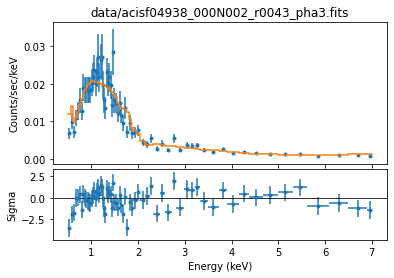

In [58]:
plot_fit_delchi(99)

# Errr...

So, this doesn't look great. The reason is that we've defined a background model which is to be fit with just a RMF, but when we include it into the source region we end up applying both the RMF and the ARF, as `get_model` shows:

In [59]:
get_model(99)

<RSPModelPHA model instance 'apply_rmf(apply_arf((50454.152030948 * ((xsphabs.gal_99 * powlaw1d.pl_99) + (0.06576568179195134 * ((powlaw1d.bpl1_99 + powlaw1d.bpl2_99) + xsgaussian.bline1_99))))))'>

# So, what can we do?

We have to move from using `set_source` and `set_bkg_source` to using the `set_full_model` and `set_bkg_full_model` commands, where we, not Sherpa, determine what responses are used.

In [60]:
# Now I'm going to use the default dataset
load_data('data/acisf04938_000N002_r0043_pha3.fits')
rmf_final = unpack_rmf('data/acisf04938_000N002_r0043_rmf3.fits')

notice_id(1, 0.5, 7)
group_counts(20, tabStops=~get_data(1).get_mask())

read ARF file data/acisf04938_000N002_r0043_arf3.fits
read RMF file data/acisf04938_000N002_r0043_rmf3.fits
read background file data/acisf04938_000N002_r0043_pha3.fits


By using the `full_model` variant we have to explicitly add the response:

In [61]:
bkg_model = powlaw1d.bpl1_1 + powlaw1d.bpl2_1 + xsgaussian.bline1_1

bline1_1.linee = 2
set_par(bline1_1.sigma, 0.01, frozen=True)

set_bkg_full_model(rmf_final(bkg_model))

When you are using `full_model` a few commands work differently (they error out), but most commands will work as normal:

In [62]:
fit_bkg(1)

Dataset               = 1
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 3854.57
Final fit statistic   = 162.075 at function evaluation 540
Data points           = 158
Degrees of freedom    = 152
Probability [Q-value] = 0.273057
Reduced statistic     = 1.06628
Change in statistic   = 3692.49
   bpl1_1.gamma   0.580964     +/- 0.0507078   
   bpl1_1.ampl    901.288      +/- 25.0317     
   bpl2_1.gamma   -3.56332     +/- 1.49668     
   bpl2_1.ampl    0.213999     +/- 0.616455    
   bline1_1.LineE   2.14233      +/- 0.00800688  
   bline1_1.norm   120.427      +/- 16.0771     


In [63]:
# Just check convergence
fit_bkg(1)

Dataset               = 1
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 162.075
Final fit statistic   = 162.075 at function evaluation 8
Data points           = 158
Degrees of freedom    = 152
Probability [Q-value] = 0.273057
Reduced statistic     = 1.06628
Change in statistic   = 2.71987e-07
   bpl1_1.gamma   0.580862     +/- 0.0507626   
   bpl1_1.ampl    901.289      +/- 25.0317     
   bpl2_1.gamma   -3.56725     +/- 1.49504     
   bpl2_1.ampl    0.212377     +/- 0.622157    
   bline1_1.LineE   2.14233      +/- 0.00800634  
   bline1_1.norm   120.42       +/- 16.0774     


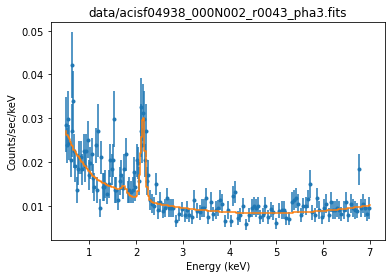

In [64]:
plot_bkg_fit()

This looks good.

It begins to get fun when we want to set the source model, because we need to scale the background model to match the source. The factors we have to care about are

- BACKSCAL
- AREASCAL
- do we care about exposures (are we working with rates or counts)?

Fortunately the [get_bkg_scale](https://cxc.cfa.harvard.edu/sherpa/ahelp/get_bkg_scale.html) can normally do the complicated part of dividing and multiplying values together:

In [65]:
get_bkg_scale(units='counts')

0.06576568179195134

In [66]:
get_bkg_scale(units='rate')

0.06576568179195134

For this dataset the source and background exposures are the same - that is

In [67]:
print(get_exposure())
print(get_exposure() == get_exposure(bkg_id=1))

50454.152030948
True


which is why the `units` setting to `get_bkg_scale` doesn't make a difference.

In [68]:
bscale = get_bkg_scale()

So, the model expression we want to use is

    source_response(source model) + bscale * some_response(background model)
    
where `source_response` is the RMF + ARF for the source and `some_response` is just the RMF term (i.e. `rmf_final`)$\ddagger$.

---

$\ddagger$ - if the background response was different then we'd need to be more careful about exactly which responses were used.

In [69]:
src_model = xsphabs.gal_1 * powlaw1d.pl_1

srsp = get_response()

set_full_model(srsp(src_model) + bscale * rmf_final(bkg_model))

In [70]:
print(get_model())

(apply_rmf(apply_arf((50454.152030948 * (xsphabs.gal_1 * powlaw1d.pl_1)))) + (0.06576568179195134 * apply_rmf(((powlaw1d.bpl1_1 + powlaw1d.bpl2_1) + xsgaussian.bline1_1))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   gal_1.nH     thawed            1            0       100000 10^22 atoms / cm^2
   pl_1.gamma   thawed            1          -10           10           
   pl_1.ref     frozen            1 -3.40282e+38  3.40282e+38           
   pl_1.ampl    thawed            1            0  3.40282e+38           
   bpl1_1.gamma thawed     0.580862          -10           10           
   bpl1_1.ref   frozen            1 -3.40282e+38  3.40282e+38           
   bpl1_1.ampl  thawed      901.289            0  3.40282e+38           
   bpl2_1.gamma thawed     -3.56725          -10           10           
   bpl2_1.ref   frozen            1 -3.40282e+38  3.40282e+38           
   bpl2_1.ampl  

One important issue here is that the background parameters have not changed significantly after the `fit` call below, which is nice.

In [71]:
fit(1)

Dataset               = 1
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 4.15168e+11
Final fit statistic   = 225.084 at function evaluation 403
Data points           = 225
Degrees of freedom    = 216
Probability [Q-value] = 0.32166
Reduced statistic     = 1.04206
Change in statistic   = 4.15168e+11
   gal_1.nH       0.0450469    +/- 0.0374077   
   pl_1.gamma     2.11138      +/- 0.126576    
   pl_1.ampl      8.01896e-05  +/- 8.64951e-06 
   bpl1_1.gamma   0.581986     +/- 0.0469375   
   bpl1_1.ampl    900.497      +/- 0           
   bpl2_1.gamma   -3.52209     +/- 1.41623     
   bpl2_1.ampl    0.239695     +/- 0.668417    
   bline1_1.LineE   2.14278      +/- 0.00805724  
   bline1_1.norm   118.468      +/- 15.862      


In [72]:
# Check stability
fit(1)

Dataset               = 1
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 225.084
Final fit statistic   = 225.084 at function evaluation 11
Data points           = 225
Degrees of freedom    = 216
Probability [Q-value] = 0.32166
Reduced statistic     = 1.04206
Change in statistic   = 4.19452e-06
   gal_1.nH       0.0450748    +/- 0.0374314   
   pl_1.gamma     2.11144      +/- 0.126596    
   pl_1.ampl      8.0195e-05   +/- 8.65153e-06 
   bpl1_1.gamma   0.582103     +/- 0.0468559   
   bpl1_1.ampl    900.497      +/- 0           
   bpl2_1.gamma   -3.51791     +/- 1.41784     
   bpl2_1.ampl    0.241658     +/- 0.66174     
   bline1_1.LineE   2.14278      +/- 0.00805786  
   bline1_1.norm   118.474      +/- 15.8618     


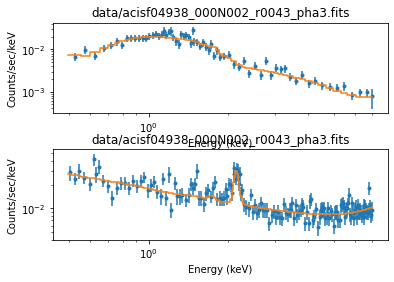

In [73]:
plot('fit', 'bkgfit', xlog=True, ylog=True)

Running an error analysis can shake out odd behavior (although as shown above we'd have likely come across odd behavior with the `fit` call):

In [74]:
conf(1)

bpl1_1.ampl lower bound:	-24.9131
bline1_1.norm lower bound:	-15.8541
bpl1_1.ampl upper bound:	24.9131
bline1_1.norm upper bound:	15.8541
pl_1.gamma lower bound:	-0.129112
bpl2_1.gamma lower bound:	-1.23127
bline1_1.LineE lower bound:	-0.0103652
bpl2_1.gamma upper bound:	0.975006
bline1_1.LineE upper bound:	0.00994993
bpl2_1.ampl lower bound:	-0.219497
gal_1.nH lower bound:	-0.0372272
pl_1.gamma upper bound:	0.136703
bpl2_1.ampl upper bound:	1.3952
pl_1.ampl lower bound:	-8.36572e-06
gal_1.nH upper bound:	0.0391022
bpl1_1.gamma lower bound:	-0.0420127
bpl1_1.gamma upper bound:	0.0472381
pl_1.ampl upper bound:	9.55086e-06
Dataset               = 1
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2datavar
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   gal_1.nH        0.0450748   -0.0372272    0.0391022
   pl_1.gam